# Temporal Convolutional Network
In this notebook, we show an example of how TCNs can be used with darts.

In [1]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally
fix_pythonpath_if_working_locally()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import TCNModel, RNNModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, r2_score
from darts.utils.missing_values import fill_missing_values

In [3]:
def transform_data(series, train, val):
    transformer = Scaler()
    train_transformed = transformer.fit_transform(train)
    val_transformed = transformer.transform(val)
    ts_transformed = transformer.transform(series)
    return ts_transformed, train_transformed, val_transformed

In [4]:
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(8,5))
    if (start_date):
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label='actual')
    pred_series.plot(label=('historic ' + forecast_type + ' forecasts'))
    plt.title('R2: {}'.format(r2_score(ts_transformed.univariate_component(0), pred_series)))
    plt.legend();

## Air passengers dataset
Since this dataset contains strong yearly seasonality, we will enhance our univariate time series of air passengers to a 13-dimensional multivariate time series containing a one-hot encoded component that for every month.

In [5]:
# Read data:
df = pd.read_csv('AirPassengers.csv', delimiter=",")
ts = TimeSeries.from_dataframe(df, 'Month', ['#Passengers']).add_datetime_attribute('month', True)

# Create training and validation sets:
train, val = ts.split_after(pd.Timestamp('19580801'))

In [6]:
ts_transformed, train_transformed, val_transformed = transform_data(ts, train, val)

When instantiating the model, we have to make sure to account for every dimension in the training time series in `input_size`. In this case, since we add a new component for every month, we have a value of 13.
Additionally, since we later want to simulate a historic forecast 6 months into the future, we have to make sure the `target_length` parameter of our `TCNModel` instance has a value of at least 6. 

All the other parameters were chosen by trying out a few different combinations, but they are probably still far from the ideal set.
If we don't specify the `num_layers` parameter, it will be chosen automatically to be the minimum number to ensure full history coverage for every entry in the output, i.e. every output will be dependent on the whole input.

In [7]:
model_air = TCNModel(
    input_size=13,
    n_epochs=1000, 
    input_length=20, 
    target_length=6, 
    dropout=0.1, 
    dilation_base=2, 
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=0
)

[2020-11-09 10:53:09,141] INFO | darts.models.tcn_model | Number of layers chosen: 2
[2020-11-09 10:53:09,141] INFO | darts.models.tcn_model | Number of layers chosen: 2


In [8]:
model_air.fit(
    training_series=train_transformed,
    target_series=train_transformed['0'],
    val_training_series=val_transformed,
    val_target_series=val_transformed['0'],
    verbose=True
)

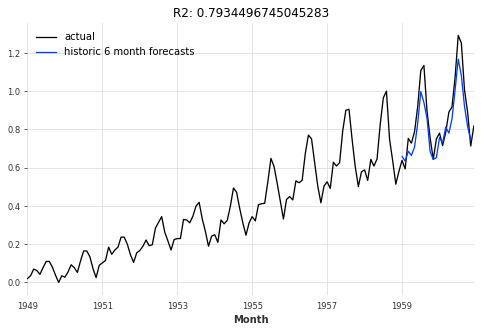

In [9]:
pred_series = model_air.historical_forecasts(
    ts_transformed,
    target_series=ts_transformed['0'],
    start=pd.Timestamp('19580801'), 
    forecast_horizon=6,
    use_full_target_length=True,
    retrain=False
)
display_forecast(pred_series, ts_transformed, '6 month')

## Monthly sunspots
Let's try using the `TCNModel` on a more complex and much bigger dataset.

In [10]:
df2 = pd.read_csv('monthly-sunspots.csv', delimiter=",")
series_sunspot = TimeSeries.from_dataframe(df2, 'Month', ['Sunspots'])
series_sunspot = series_sunspot.add_datetime_attribute('month', True)
train_sp, val_sp = series_sunspot.split_after(pd.Timestamp('19401001'))

series_sp_transformed, train_sp_transformed, val_sp_transformed = transform_data(series_sunspot, train_sp, val_sp)

In [11]:
model_sun = TCNModel(
    input_size=13,
    n_epochs=10, 
    input_length=250,
    target_length=36,
    dropout=0, 
    dilation_base=2, 
    weight_norm=True,
    kernel_size=3,
    num_filters=6,
    nr_epochs_val_period=1,
    random_state=0
)

[2020-11-09 10:53:45,584] INFO | darts.models.tcn_model | Number of layers chosen: 6
[2020-11-09 10:53:45,584] INFO | darts.models.tcn_model | Number of layers chosen: 6


In [12]:
model_sun.fit(
    training_series=train_sp_transformed,
    target_series=train_sp_transformed['0'],
    val_training_series=val_sp_transformed,
    val_target_series=val_sp_transformed['0'],
    verbose=True
)

Training loss: 0.0282, validation loss: 0.0499


[2020-11-09 10:54:13,063] WARNING | darts.timeseries | The inferred frequency does not match the value of the "freq" argument.
[2020-11-09 10:54:13,149] WARNING | darts.timeseries | The inferred frequency does not match the value of the "freq" argument.



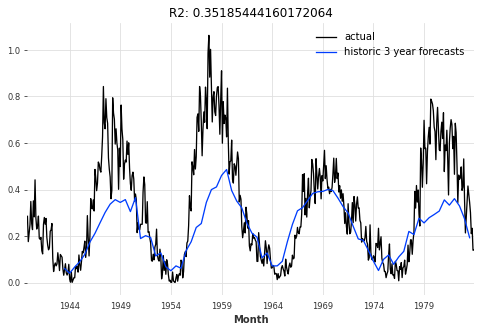

In [13]:
pred_series = model_sun.historical_forecasts(
    training_series=series_sp_transformed,
    target_series=series_sp_transformed['0'],
    start=pd.Timestamp('19401001'), 
    forecast_horizon=36,
    stride=6,
    retrain=False,
    use_full_target_length=True,
    verbose=True
)
display_forecast(pred_series, series_sp_transformed, '3 year', start_date=pd.Timestamp('19391001'))

## Daily energy production

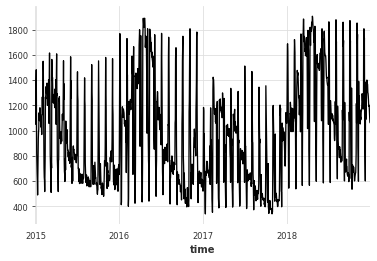

In [14]:
df3 = pd.read_csv('energy_dataset.csv', delimiter=",")
df3['time'] = pd.to_datetime(df3['time'], utc=True)
df3['time']= df3.time.dt.tz_localize(None)
df3_day_avg = df3.groupby(df3['time'].astype(str).str.split(" ").str[0]).mean().reset_index()
series_en = fill_missing_values(TimeSeries.from_dataframe(df3_day_avg, 'time', ['generation hydro run-of-river and poundage']), 'auto')
series_en.plot()

In [15]:
series_en = series_en.add_datetime_attribute('day', True)
train_en, val_en = series_en.split_after(pd.Timestamp('20170901'))
series_en_transformed, train_en_transformed, val_en_transformed = transform_data(series_en, train_en, val_en)

In [16]:
model_en = TCNModel(
    input_size=series_en.width,
    n_epochs=20, 
    input_length=365,
    target_length=7, 
    dropout=0, 
    dilation_base=2, 
    weight_norm=True,
    kernel_size=7,
    num_filters=4,
    nr_epochs_val_period=1,
    random_state=0
)

[2020-11-09 10:54:15,665] INFO | darts.models.tcn_model | Number of layers chosen: 5
[2020-11-09 10:54:15,665] INFO | darts.models.tcn_model | Number of layers chosen: 5


In [17]:
model_en.fit(
    training_series=train_en_transformed,
    target_series=train_en_transformed['0'],
    val_training_series=val_en_transformed,
    val_target_series=val_en_transformed['0'],
    verbose=True
)

Training loss: 0.0234, validation loss: 0.0327


[2020-11-09 10:54:34,711] WARNING | darts.timeseries | The inferred frequency does not match the value of the "freq" argument.



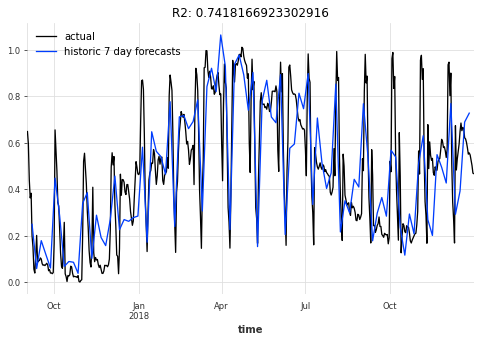

In [18]:
pred_series = model_en.historical_forecasts(
    series_en_transformed,
    start=pd.Timestamp('20170901'), 
    forecast_horizon=7,
    stride=5,
    retrain=False,
    use_full_target_length=True,
    verbose=True
)
display_forecast(pred_series, series_en_transformed, '7 day', start_date=pd.Timestamp('20170901'))